# Simulating real-time fMRI classification

In [43]:
#from delphi.networks.ConvNets import BrainStateClassifier3d
import nibabel as nib
import glob
import numpy as np
import os
from delphi.utils.plots import classification_timecourse
from delphi.utils.tools import z_transform
import torch
import pandas as pd

In [130]:
model_path = "../volumetric_approach/models/vol-multitask-classifier-withrest_fold-00"
model = BrainStateClassifier3d(model_path)
model.eval();

Loading from config file ../volumetric_approach/models/vol-multitask-classifier-withrest_fold-00/config.yaml


In [164]:
TASKID = "SOCIAL"

ev_files = sorted(glob.glob(os.path.join(f"/media/philippseidel/5tb/hcp_download/{TASKID}/logs/*_RL.txt")))
ev_files

['/media/philippseidel/5tb/hcp_download/SOCIAL/logs/mental_RL.txt',
 '/media/philippseidel/5tb/hcp_download/SOCIAL/logs/rnd_RL.txt']

In [165]:
# load a test nifti
subID = "107018"
path2nifti = f"/media/philippseidel/5tb/hcp_download/{TASKID}/sub{subID}_RL.nii.gz"
# load the data
data = nib.load(path2nifti).get_fdata()
data = np.nan_to_num(z_transform(data))

In [166]:
data = torch.tensor(data)

In [167]:
predicted = np.zeros(data.size()[-1])
probs = np.zeros((data.size()[-1], model.config["n_classes"]))
for i in range(data.size()[-1]):
    in_vol = data[:,:,:,i].unsqueeze(0).unsqueeze(0)
    
    out = model.SM(model(in_vol.float()))
    probs[i,:] = out.detach().cpu().numpy()
    predicted[i] = np.argmax(probs[i,:])

In [168]:
model.config["class_labels"]

['body',
 'face',
 'footleft',
 'footright',
 'handleft',
 'handright',
 'match',
 'mental',
 'place',
 'relation',
 'rest_MOTOR',
 'rest_RELATIONAL',
 'rest_SOCIAL',
 'rest_WM',
 'rnd',
 'tongue',
 'tool']

In [169]:
#labels_of_interest = sorted(["body", "face", "place", "tool", "rest_WM"])
#labels_of_interest = sorted(["handleft", "handright", "footright", "footleft", "tongue", f"rest_{TASKID}"])
labels_of_interest = sorted(["mental", "rnd", f"rest_{TASKID}"])
indices = [i for i, lbl in enumerate(model.config["class_labels"]) if lbl in labels_of_interest]
indices

[7, 12, 14]

In [178]:
labels_of_interest

['mental', 'rest_SOCIAL', 'rnd']

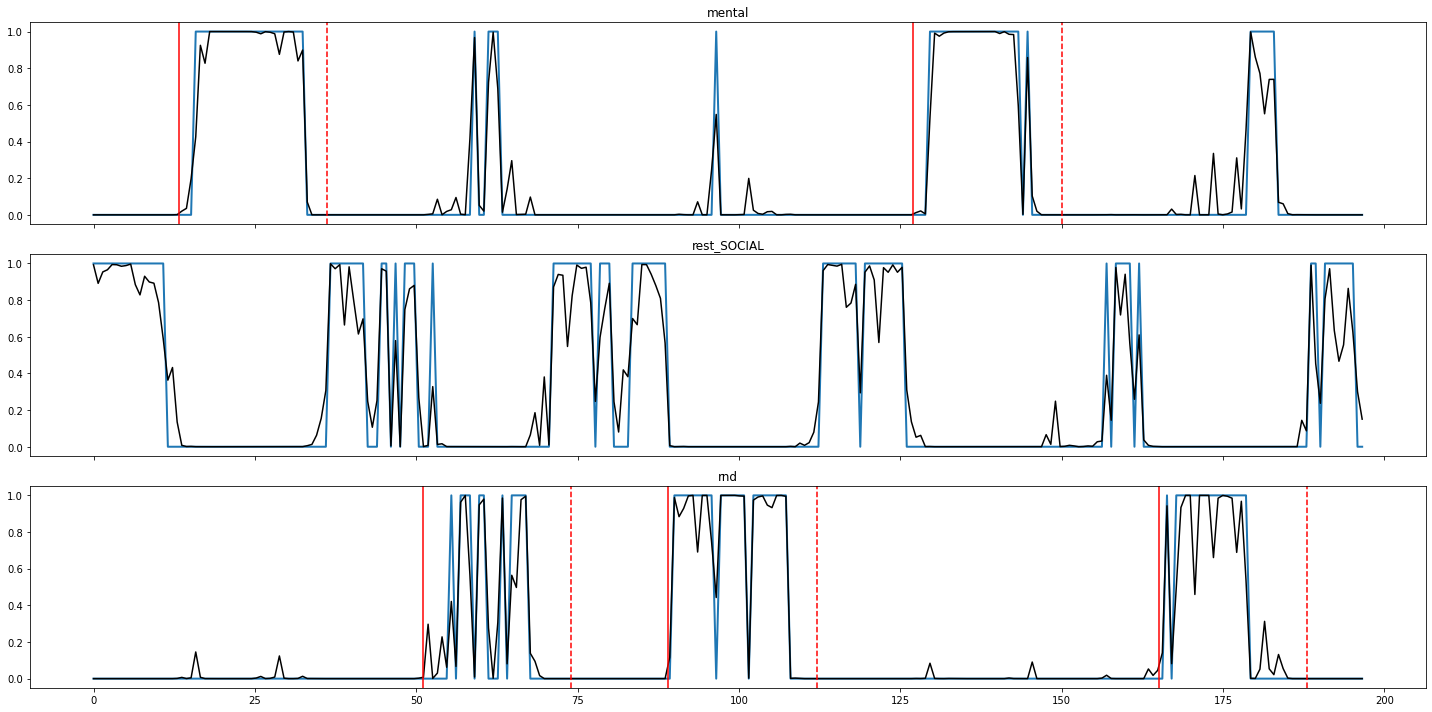

In [180]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(labels_of_interest),1, figsize=(20,10), sharex=True, sharey=True)

x = np.arange(len(predicted))*.72

# the HRF peaks at about 4-6 seconds after the stimulus onset.
bold_lag = 5

ctr = 0
for i, ax in enumerate(axes):
    ax.plot(x, predicted==indices[i], linewidth=2)
    ax.plot(x, probs[:,indices[i]], color='black')
    if "rest" in labels_of_interest[i]:
        pass
    else:
        onset = pd.read_table(ev_files[ctr], header=None)
        for j, on in enumerate(onset[0].values):
            ax.axvline(on+bold_lag, color='r')
            ax.axvline(on+onset[1].values[0]+bold_lag, color='r', linestyle="--")
        ctr+=1
    ax.set_title(labels_of_interest[i])
    
fig.tight_layout()

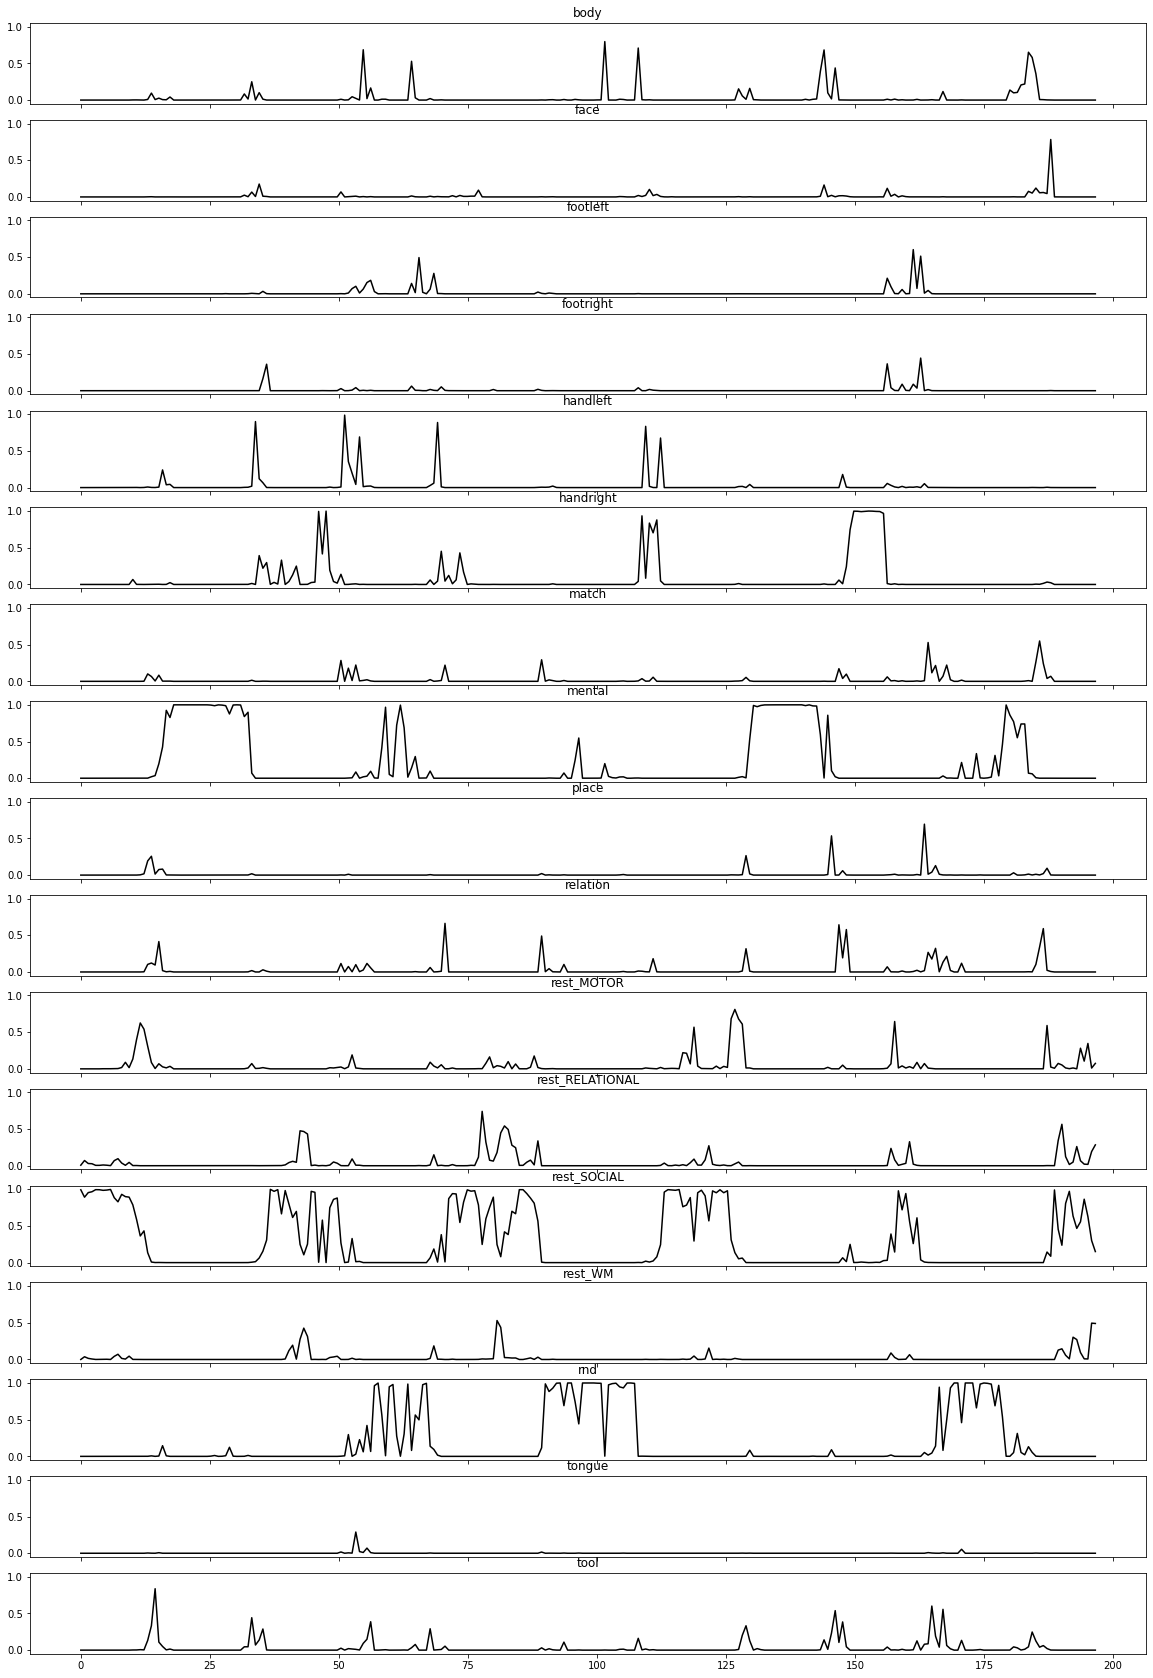

In [171]:
fig, axes = plt.subplots(model.config["n_classes"],1, figsize=(20,30), sharex=True, sharey=True)

x = np.arange(len(predicted))*.72

# the HRF peaks at about 4-6 seconds after the stimulus onset.
bold_lag = 5

ctr = 0
for i, ax in enumerate(axes):
    ax.plot(x, probs[:,i], color='black')
    ax.set_title(model.config["class_labels"][i])
    


In [177]:
len(probs.sum(axis=1))

274